In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import random
import copy
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import pickle

In [25]:
base_path = r'C:\Users\RACYM\Desktop\fac\M2_PFE\datasets\CIC-DDoS2019\\'

cic_ddos2019 = {
    'DNS-test': pd.read_parquet(base_path + 'DNS-testing.parquet', engine='fastparquet'),
    'LDAP-test': pd.read_parquet(base_path + 'LDAP-testing.parquet', engine='fastparquet'),
    'LDAP-train': pd.read_parquet(base_path + 'LDAP-training.parquet', engine='fastparquet'),
    'MSSQL-test': pd.read_parquet(base_path + 'MSSQL-testing.parquet', engine='fastparquet'),
    'MSSQL-train': pd.read_parquet(base_path + 'MSSQL-training.parquet', engine='fastparquet'),
    'NetBIOS-test': pd.read_parquet(base_path + 'NetBIOS-testing.parquet', engine='fastparquet'),
    'NetBIOS-train': pd.read_parquet(base_path + 'NetBIOS-training.parquet', engine='fastparquet'),
    'NTP-test': pd.read_parquet(base_path + 'NTP-testing.parquet', engine='fastparquet'),
    'Portmap-train': pd.read_parquet(base_path + 'Portmap-training.parquet', engine='fastparquet'),
    'SNMP-test': pd.read_parquet(base_path + 'SNMP-testing.parquet', engine='fastparquet'),
    'Syn-test': pd.read_parquet(base_path + 'Syn-testing.parquet', engine='fastparquet'),
    'Syn-train': pd.read_parquet(base_path + 'Syn-training.parquet', engine='fastparquet'),
    'TFTP-test': pd.read_parquet(base_path + 'TFTP-testing.parquet', engine='fastparquet'),
    'UDPLag-test': pd.read_parquet(base_path + 'UDPLag-testing.parquet', engine='fastparquet'),
    'UDPLag-train': pd.read_parquet(base_path + 'UDPLag-training.parquet', engine='fastparquet'),
    'UDP-test': pd.read_parquet(base_path + 'UDP-testing.parquet', engine='fastparquet'),
    'UDP-train': pd.read_parquet(base_path + 'UDP-training.parquet', engine='fastparquet'),
}

# merging between train sets and test sets for each attack type
cic_ddos2019_merged = {
    'DNS': cic_ddos2019['DNS-test'],
    'LDAP': pd.concat([cic_ddos2019['LDAP-train'], cic_ddos2019['LDAP-test']], ignore_index=True),
    'MSSQL': pd.concat([cic_ddos2019['MSSQL-train'], cic_ddos2019['MSSQL-test']], ignore_index=True),
    'NetBIOS': pd.concat([cic_ddos2019['NetBIOS-train'], cic_ddos2019['NetBIOS-test']], ignore_index=True),    
    'NTP': cic_ddos2019['NTP-test'],
    'Portmap': cic_ddos2019['Portmap-train'],
    'SNMP': cic_ddos2019['SNMP-test'],
    'Syn': pd.concat([cic_ddos2019['Syn-train'], cic_ddos2019['Syn-test']], ignore_index=True),
    'TFTP': cic_ddos2019['TFTP-test'],
    'UDPLag': pd.concat([cic_ddos2019['UDPLag-train'], cic_ddos2019['UDPLag-test']], ignore_index=True),
    'UDP': pd.concat([cic_ddos2019['UDP-train'], cic_ddos2019['UDP-test']], ignore_index=True),
}

# merging all attack types 
cic_ddos2019_all = pd.concat(cic_ddos2019_merged.values(), ignore_index=True)

# dropping constant features
cic_ddos2019_all.drop(['Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'FIN Flag Count',
 'PSH Flag Count',
 'ECE Flag Count',
 'Fwd Avg Bytes/Bulk',
 'Fwd Avg Packets/Bulk',
 'Fwd Avg Bulk Rate',
 'Bwd Avg Bytes/Bulk',
 'Bwd Avg Packets/Bulk',
 'Bwd Avg Bulk Rate'], axis=1, inplace=True)

# dropping columns highly correlated with other columns
cic_ddos2019_all.drop(['Bwd Packets Length Total',
                                'Fwd Packet Length Mean',
                                'Bwd Packet Length Std', 'Flow IAT Std', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
                                'Fwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Max', 'Fwd Packets/s', 'Packet Length Min', 'Packet Length Mean', 'Packet Length Std',
                                'RST Flag Count', 'Avg Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets',
                                'Subflow Bwd Bytes', 'Active Min', 'Idle Mean', 'Idle Max', 'Idle Min'], axis=1, inplace=True)

# Outlier treatement
labels = cic_ddos2019_all['Label']
cic_ddos2019_all = (cic_ddos2019_all.iloc[:,:-1] - cic_ddos2019_all.iloc[:,:-1].mean()) / cic_ddos2019_all.iloc[:,:-1].std()
cic_ddos2019_all['Protocol'], _ = pd.factorize(cic_ddos2019_all['Protocol'])
cic_ddos2019_all['Flow Duration'] = np.log1p(cic_ddos2019_all['Flow Duration']).clip(upper=0)
cic_ddos2019_all['Total Fwd Packets'] = np.log1p(cic_ddos2019_all['Total Fwd Packets']).clip(upper=0.2)
cic_ddos2019_all['Total Backward Packets'] = np.log1p(cic_ddos2019_all['Total Backward Packets']).clip(upper=0.2)
cic_ddos2019_all['Fwd Packets Length Total'] = np.log1p(cic_ddos2019_all['Fwd Packets Length Total']).clip(upper=0.5)
cic_ddos2019_all['Fwd Packet Length Max'] = np.log1p(cic_ddos2019_all['Fwd Packet Length Max'].clip(lower=0)).clip(upper=1.25)

cic_ddos2019_all['Fwd Packet Length Min'] = np.log1p(cic_ddos2019_all['Fwd Packet Length Min'].clip(lower=0)).clip(upper=2)
cic_ddos2019_all['Fwd Packet Length Std'] = np.log1p(cic_ddos2019_all['Fwd Packet Length Std']).clip(upper=-0.3)
cic_ddos2019_all['Bwd Packet Length Max'] = np.log1p(cic_ddos2019_all['Bwd Packet Length Max']).clip(upper=-0.16)
cic_ddos2019_all['Bwd Packet Length Min'] = cic_ddos2019_all['Bwd Packet Length Min'].clip(lower=0, upper=10)
cic_ddos2019_all['Bwd Packet Length Mean'] = cic_ddos2019_all['Bwd Packet Length Mean'].clip(lower=0, upper=15)
cic_ddos2019_all['Flow Bytes/s'] = np.log1p(cic_ddos2019_all['Flow Bytes/s']).clip(upper=-0.1)

cic_ddos2019_all['Flow Packets/s'] = np.log1p(cic_ddos2019_all['Flow Packets/s']).clip(upper=0.2)
cic_ddos2019_all['Flow IAT Mean'] = np.log1p(cic_ddos2019_all['Flow IAT Mean']).clip(upper=2)
cic_ddos2019_all['Flow IAT Max'] = np.log1p(cic_ddos2019_all['Flow IAT Max']).clip(upper=1)
cic_ddos2019_all['Flow IAT Min'] = np.log1p(cic_ddos2019_all['Flow IAT Min']).clip(upper=1)
cic_ddos2019_all['Bwd IAT Total'] = np.log1p(cic_ddos2019_all['Bwd IAT Total']).clip(upper=-0.15)
cic_ddos2019_all['Bwd IAT Mean'] = np.log1p(cic_ddos2019_all['Bwd IAT Mean']).clip(upper=-0.2)

cic_ddos2019_all['Bwd IAT Min'] = np.log1p(cic_ddos2019_all['Bwd IAT Min']).clip(upper=1)
cic_ddos2019_all['Fwd PSH Flags'], _ = pd.factorize(cic_ddos2019_all['Fwd PSH Flags'])
cic_ddos2019_all['Fwd Header Length'] = cic_ddos2019_all['Fwd Header Length'].clip(lower=-20)
cic_ddos2019_all['Bwd Header Length'] = cic_ddos2019_all['Bwd Header Length'].clip(lower=-100)
cic_ddos2019_all['Bwd Packets/s'] = np.log1p(cic_ddos2019_all['Bwd Packets/s']).clip(upper=1)
cic_ddos2019_all['Packet Length Max'] = cic_ddos2019_all['Packet Length Max'].clip(upper=6)

cic_ddos2019_all['Packet Length Variance'] = np.log1p(cic_ddos2019_all['Packet Length Variance']).clip(lower=0, upper=2)
cic_ddos2019_all['SYN Flag Count'], _ = pd.factorize(np.log1p(cic_ddos2019_all['SYN Flag Count']))
cic_ddos2019_all['ACK Flag Count'], _ = pd.factorize(cic_ddos2019_all['ACK Flag Count'])
cic_ddos2019_all['URG Flag Count'], _ = pd.factorize(np.log1p(cic_ddos2019_all['URG Flag Count']))
cic_ddos2019_all['CWE Flag Count'], _ = pd.factorize(np.log1p(cic_ddos2019_all['CWE Flag Count']))
cic_ddos2019_all['Down/Up Ratio'] = cic_ddos2019_all['Down/Up Ratio'].clip(lower=0, upper=4)

cic_ddos2019_all['Init Fwd Win Bytes'] = np.log1p(cic_ddos2019_all['Init Fwd Win Bytes']).clip(upper=-0.2)
cic_ddos2019_all['Init Bwd Win Bytes'] = np.log1p(cic_ddos2019_all['Init Bwd Win Bytes']).clip(upper=1)
cic_ddos2019_all['Fwd Act Data Packets'] = np.log1p(cic_ddos2019_all['Fwd Act Data Packets']).clip(upper=1)
cic_ddos2019_all['Fwd Seg Size Min'] = cic_ddos2019_all['Fwd Seg Size Min']
cic_ddos2019_all['Active Mean'] = np.log1p(cic_ddos2019_all['Active Mean']).clip(upper=-0.109)
cic_ddos2019_all['Active Std'] = np.log1p(cic_ddos2019_all['Active Std']).clip(upper=-0.115)

cic_ddos2019_all['Active Max'] = np.log1p(cic_ddos2019_all['Active Max']).clip(upper=0)
cic_ddos2019_all['Idle Std'] = np.log1p(cic_ddos2019_all['Idle Std']).clip(upper=-0.115)

cic_ddos2019_all['Label'] = labels

# Normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
cic_ddos2019_all_c = scaler.fit_transform(cic_ddos2019_all.iloc[:,:-1].to_numpy())
cic_ddos2019_all = pd.DataFrame(cic_ddos2019_all_c, columns=cic_ddos2019_all.columns[:-1])
cic_ddos2019_all['Label'] = labels


In [26]:
import DDoS_cic_v2
from importlib import reload
reload(DDoS_cic_v2)

from DDoS_cic_v2 import AIRS

In [27]:
map_C = {'Portmap' : 0,
'NetBIOS' : 1,
'DrDoS_NetBIOS' : 2,
'DrDoS_DNS' : 3,
'DrDoS_LDAP' : 4,
'LDAP' : 5,
'DrDoS_SNMP' : 6,
'UDP' : 7,
'DrDoS_UDP' : 8,
'UDP-lag' : 9,
'UDPLag' : 9,
'Benign' : 10,
'DrDoS_MSSQL' : 11,
'MSSQL' : 12,
'WebDDoS' : 13,
'Syn' : 14,
'TFTP' : 15,
'DrDoS_NTP' : 16,
}
map_B = {'Portmap' : 0,
'NetBIOS' : 1,
'DrDoS_NetBIOS' : 1,
'DrDoS_NTP' : 11,
'DrDoS_LDAP' : 3,
'LDAP' : 3,
'DrDoS_SNMP' : 4,
'UDP' : 5,
'UDP-lag' : 5,
'UDPLag' : 5,
'DrDoS_UDP' : 5,
'Benign' : 6,
'DrDoS_MSSQL' : 7,
'MSSQL' : 7,
'WebDDoS' : 8,
'Syn' : 9,
'TFTP' : 10,
'DrDoS_DNS' : 2}
map_A = {'Portmap' : 0,
'DrDoS_NTP' : 0,
'NetBIOS' : 0,
'DrDoS_LDAP' : 0,
'UDP' : 0,
'DrDoS_SNMP' : 0,
'Benign' : 1,
'DrDoS_NetBIOS' : 0,
'DrDoS_MSSQL' : 0,
'MSSQL' : 0,
'WebDDoS' : 0,
'Syn' : 0,
'LDAP' : 0,
'TFTP' : 0,
'UDP-lag' : 0,
'UDPLag' : 0,
'DrDoS_UDP' : 0,
'DrDoS_DNS' : 0,
'Attack' : 0}
def toMCPool(x_test, y_test, model):
    new_x_test = []
    for antigene, _class in zip(x_test, y_test):
        # finding the mc cell with highest affinity with antigene
        best_aff = 0.0
        for cell in model.MC_POOL.get(_class):
            aff = model.affinity(antigene, cell.vector)
            if aff > best_aff:
                best_aff = aff
                best_aff_vector = cell.vector
        
        # adding the best aff vector to the new xtest
        new_x_test.append(best_aff_vector)
    return np.array(new_x_test)

# Cross Validation

In [ ]:
from sklearn.model_selection import KFold

# dataset_A = pd.concat([cic_ddos2019_all[cic_ddos2019_all['Label'] != 'Benign'].sample(n=8000),
#                        cic_ddos2019_all[cic_ddos2019_all['Label'] == 'Benign'].sample(n=8000)],
#                        ignore_index=True)
# dataset_A['Label'] = dataset_A['Label'].map(map_A)
dataset_B = pd.concat([cic_ddos2019_all[cic_ddos2019_all['Label'] == 'Benign'].sample(n=3000),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'Portmap'].sample(n=685),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_DNS'].sample(n=3000),

                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'NetBIOS'].sample(n=644),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_NetBIOS'].sample(n=598),

                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_LDAP'].sample(n=1100),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'LDAP'].sample(n=1900),

                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_SNMP'].sample(n=2717),

                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'UDP'].sample(n=2000),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'UDP-lag'].sample(n=400),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'UDPLag'].sample(n=50),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_UDP'].sample(n=550),

                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_MSSQL'].sample(n=1500),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'MSSQL'].sample(n=1500),

                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'WebDDoS'].sample(n=51),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'Syn'].sample(n=3000),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'TFTP'].sample(n=3000),
                       cic_ddos2019_all[cic_ddos2019_all['Label'] == 'DrDoS_NTP'].sample(n=3000),
                       ],
                       ignore_index=True)
dataset_B['Label'] = dataset_B['Label'].map(map_B)

smote = SMOTE()
features_resampled, classes_resampled = smote.fit_resample(dataset_B.iloc[:,:-1], dataset_B.iloc[:,-1])
dataset_B = pd.DataFrame(features_resampled, columns=features_resampled.columns)
dataset_B['Label'] = classes_resampled

reports = [] # to store the reports of each fold
kfold = KFold(n_splits=5, shuffle=True, random_state=10)
for fold, (train_index, test_index) in enumerate(kfold.split(dataset_B)):
    print(f"Fold {fold + 1}")
    dataset = dataset_B.to_numpy()
    train_set = dataset[train_index]
    test_set = dataset[test_index]
    x_test = test_set[:,:-1]
    y_test = test_set[:,-1]
    
    # AIRS training
    Model_B = AIRS(train_set=train_set,
                    CLONAL_RATE=0.8,
                    HYPER_CLONAL_RATE=100,
                    CLASS_NUMBER=12,
                    MC_INIT_RATE=0.06,
                    MUTATION_RATE=0.05,
                    TOTAL_RESSOURCES=10,
                    MAX_ITER=100,
                    AFFINITY_THRESHOLD_SCALAR=0.5,
                    KNN_K= 5)
    
    Model_B.AFFINITY_THRESHOLD = 0.39465084524746724
    Model_B.train()


    # MLP training
    mcA_x_raw, mcA_y_raw = Model_B.getMcPOOLasDataset()
    mcA_x, mcA_y = smote.fit_resample(mcA_x_raw, mcA_y_raw)

    HybridModel = RandomForestClassifier(
    n_estimators=1000,
    criterion='gini',
    max_depth=None,
    random_state=10,
    verbose = False
    )

    HybridModel.fit(mcA_x, mcA_y)
    y_pred_A = HybridModel.predict(toMCPool(x_test, y_test, Model_B))


    # saving the results of the fold
    reports.append(classification_report(y_test, y_pred_A, output_dict=True))






Fold 1
Training Started

progression : 1440 / 28800   -   5.0%
progression : 2880 / 28800   -   10.0%
progression : 4320 / 28800   -   15.0%
progression : 5760 / 28800   -   20.0%
progression : 7200 / 28800   -   25.0%
progression : 8640 / 28800   -   30.0%
progression : 10080 / 28800   -   35.0%
progression : 11520 / 28800   -   40.0%
progression : 12960 / 28800   -   45.0%
progression : 14400 / 28800   -   50.0%
progression : 15840 / 28800   -   55.00000000000001%
progression : 17280 / 28800   -   60.0%
progression : 18720 / 28800   -   65.0%
progression : 20160 / 28800   -   70.0%
progression : 21600 / 28800   -   75.0%
progression : 23040 / 28800   -   80.0%
progression : 24480 / 28800   -   85.0%
progression : 25920 / 28800   -   90.0%
progression : 27360 / 28800   -   95.0%
progression : 28800 / 28800   -   100.0%
Training complete

Fold 2
Training Started

progression : 1440 / 28800   -   5.0%
progression : 2880 / 28800   -   10.0%
progression : 4320 / 28800   -   15.0%
progress

In [31]:
accuracies = []
for report in reports:
    print(report['accuracy'])
    accuracies.append(report['accuracy'])

0.7938888888888889
0.80625
0.8109722222222222
0.8156944444444445
0.7833333333333333


(0.7, 0.8564791666666667)

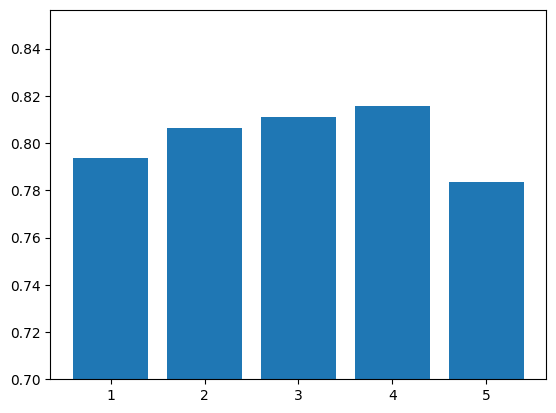

In [ ]:
fig, ax = plt.subplots()
ax.bar(['1','2','3','4','5'], accuracies)
ax.set_ylim(0.7)